# ASETS-II cases simulation

This is an example of a simulation package for conjugate heat transfer of an oscillating heat pipe. SI units are used and units are emitted

## What do we need to solve an OHP problem?

**specify properties** : Solid property, Fluid property

**set the geometries** : Computational domain, Heaters/Condensers, OHP shapes

**construct the systems** : Fluid system(1D), HeatConduction system(2D)

**initialize** : initialize the integrators and the data structs for saving

**solve**

**save/examine**

## Packages

Firstly, let's import the necessary packages, you may need to install them for the first time.

In [2]:
] activate

  Activating project at `~/.julia/environments/v1.8`


In [3]:
using Revise
using ProgressMeter
using ComputationalHeatTransfer # our main package
# using ProgressMeter # to have a progessbar when runing the simulation
using Plots # for plotting
gr()  #ploting backend (the fastest one)

Plots.GRBackend()

# Specify properties

### Solid Physical parameters

params is the HeatConductionParameters for the plate material. The numbers below represents aluminum.

In [4]:
ρₛ = 2730; # material density
cₛ  = 8.93e02; # material specific heat
kₛ  = 1.93e02; # material heat conductivity
plate_d = 1.5e-3; # effective d (The thickness of an ideal uniform thickness plate occupying the same volume)
params = HeatConductionParameters(ρₛ ,cₛ ,kₛ ,thickness=plate_d)

HeatConductionParameters(2730.0, 893.0, 193.0, 7.916682048820907e-5, 0.0015)

### Fluid Physical parameters

p_fluid contains the vapor and liquid properties at a constant reference temperature. Noted that the vapor pressure and the vapor density will be functions of temperatures during the simulation, other properties are extracted from p_fluid as an approximate value.

In [5]:
Tref = 291.2 # reference temperature
fluid_type = "Butane"
p_fluid = SaturationFluidProperty(fluid_type,Tref)

Saturation properties for Butane at constant temperature 291.2 [K]


# Set the geometries

### Geometry parameters
The 2D domain is of rectangular shape (slightly different from ASETS-II). In the future it can be of arbitrary shape using the immersedlayers.jl package.

In [6]:
Lx = 0.1524; # plate size x [m]
Ly = 0.0648; # plate size y [m]
xlim = (-Lx/2,Lx/2) # plate x limits
ylim = (-Ly/2,Ly/2) # plate y limits

(-0.0324, 0.0324)

### Set mesh size and maximum time step for plate heat conduction
Δx is controlled by Δx = α*gridPe and set having the same order of magitute of tube diameter 1e-3. Fourier number is used to give a safety "cap" of time step you can choose in the fluid module

In [7]:
Δx,Δt_max = setstepsizes(params.α,gridPe=8.0,fourier=0.3)

(0.0006333345639056725, 0.001520002953373614)

### Set up the evaporators and condensers
Right now, the OHPtype looks up a preset dictionary of OHP evaporators and condensers.

You can also customize them in the OHP DIY notebook



In [8]:
OHPtype = "ASETS-II OHP 2 LARGE HEATER"
power = 40 # total heater power in watts
Tc = Tref; # condenser temperature
eparams,cparams = OHPConfiguration(OHPtype,power,Tc,Δx);

### Set up OHP channel's shape
construct_ohp_curve is a built-in function that generates two arrays: x that contains all x values of the discrete points, and y contains all y values. x and y have the same length. 

You can also customize this function to generate an OHP shape of your choice as long as they produce x array and y array.

In [9]:
x, y = construct_ohp_curve("ASETS",Δx) # get x and y coordinates for the channel
ohp = BasicBody(x,y) # build a BasicBody based on x,y

ohpgeom = ComputationalHeatTransfer.LineSourceParams(ohp) # build a line heat source based on BasicBody

LineSourceParams{BasicBody{4877, RigidBodyTools.ClosedBody}}(Basic pointwise-specified body with 4877 points
   Current position: (0.0,0.0)
   Current angle (rad): 0.0
)

### Plot what you got so far
This is a exmaple of the compuational domain (the box) and the OHP channel serpentine (in blue)

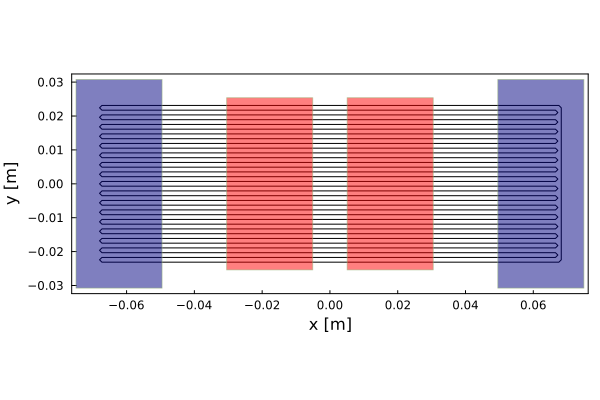

In [10]:
# plot ohp
plt = plot(ohp,fillalpha=0,linecolor=:black,xlims=xlim,ylims=ylim,framestyle = :box,xlabel="x [m]",ylabel="y [m]")

# plot heaters (red)
for ep in eparams
    plot!(ep)
end

# plot condensers (blue)
for cp in cparams
    plot!(cp)
end

# show plot
plt

# Construct the systems

### Create HeatConduction system
The solid module dealing with the 2D conduction, evaporator, condenser, and the OHP line heat source is constructed here.

In [11]:
sys_plate = HeatConduction(params,Δx,xlim,ylim,Δt_max,qline=ohpgeom,qflux=eparams,qmodel=cparams)

Unbounded Heat conduction system on a grid of size 250 x 112 and 0 static immersed points


### Create OHP inner channel system
sys_tube: fluid module system

In [12]:
sys_tube = initialize_ohpsys(fluid_type,sys_plate,p_fluid,Tref,power)

4877 point OHP system filled with Butane


# Initialize

### set time step

In [13]:
tspan = (0.0, 1.0); # start time and end time
dt_record = 0.01   # saving time interval

tstep = 1e-3     # actrual time marching step

0.001

### combine inner tube and plate together

In [16]:
u_plate = newstate(sys_plate) .+ Tref # initialize plate T field to uniform Tref
integrator_plate = init(u_plate,tspan,sys_plate) # construct integrator_plate

u_tube = newstate(sys_tube) # initialize OHP tube 
integrator_tube = init(u_tube,tspan,sys_tube); # construct integrator_tube

### initialize arrays for saving

In [17]:
sr = SimulationResult(integrator_tube,integrator_plate);

# Solve

### Run the simulation and store data

In [19]:
@showprogress for t in tspan[1]:tstep:tspan[2]

    timemarching!(integrator_tube,integrator_plate,tstep)

    if (mod(integrator_plate.t,dt_record) < 1e-6) || (mod(-integrator_plate.t,dt_record) < 1e-6)
        store!(sr,integrator_tube,integrator_plate)
    end

end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:30


# Store data

In [20]:
save_path = dirname(dirname(dirname(pwd())))*"/OHPnume/OHP2_40W_large.jld2"
save(save_path,"SimulationResult",sr)

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*